In [5]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [6]:
# Insert imports here
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.aqua.algorithms import QPE
import numpy as np
pi = np.pi
sin = np.sin
cos = np.cos

1st Implement using Matrix form and then the circuit version of the same


In [7]:
# Matrix form of pairing part of pairing Hamiltonian
from qiskit.circuit import Parameter
t = pi/12
#t = Parameter('t') #Define a universal parameter for all operators

Defining Pairing Part of Pairing Hamiltonian

In [23]:
#evolution operator : pairing part of pairing hamiltonian 
UPP = ([[1,0,0,0],[0,cos(t),complex(0,sin(t)),0],[0,complex(0,sin(t)),cos(t),0],[0,0,0,1]])
UPP
#QC for UPP
def qc(p,q):
    qc = QuantumCircuit(2)
    qc.unitary(UPP,[0,1])
    qc = transpile(qc)
    return qc #just to see 

def evoloperator2(w):
    evoloperator2 = QuantumCircuit(w)
    for p in range(w):
        for q in range(w):
            if (q > p):
                evoloperator2 = evoloperator2.compose(qc(0,1),[p,q])
    return evoloperator2

#converting the circuit into a controlled gate
UPP_Gate = evoloperator2(4).to_gate().control(1)

In [24]:
# Define the circuit for the hamiltonian. Please change the t to accomodate variable t 
# Evolution operator : Circuit version of pairing part of pairing hamiltonian
def qc2(p,q):
    qc2 = QuantumCircuit(2)
    qc2.cx(q,p)
    qc2.crx(t,p,q)
    qc2.cx(q,p)
    return qc2

# Define the unitary operation
def evoloperator(w):
    evoloperator = QuantumCircuit(w)
    for p in range(w):
        for q in range(w):
            if (q > p):
                evoloperator = evoloperator.compose(qc2(0,1),[p,q])
    return evoloperator
evoloperator(4).draw() #Just to see

#Converting circuit into controlled gate
unitary = evoloperator(4).to_gate().control(1)

Defining one body part of pairing H

In [35]:
# Operator to gate for one body part and its circuit version
tt = Parameter('tt')
tt = -p*t
UU = ([[1,0],[0,np.exp(complex(0,tt))]])
UU
#QC for UPP
def qc3(p):
    qc3 = QuantumCircuit(1)
    qc3.unitary(UU,[0])
    qc3 = transpile(qc3)
    return qc3  

def evoloperator3(w):
    evoloperator3 = QuantumCircuit(w)
    for p in range(w):
        evoloperator3 = evoloperator3.compose(qc3(0),[p])
    return evoloperator3

#converting the circuit into a controlled gate
UU_Gate = evoloperator3(4).to_gate().control(1)

Traceback (most recent call last):
  File "<ipython-input-35-167a8b83cd05>", line 3, in <module>
    tt = -p*t
NameError: name 'p' is not defined

Use %tb to get the full traceback.


Defining hubbard hamiltonian 

In [36]:
# Operator to gate for pairing part(circuit and matrix versions) 
#and one body part(circuit and matrix version)
#evolution operator : pairing part of pairing hamiltonian 
UPH = ([[1,0,0,0],[0,cos(t),complex(0,-sin(t)),0],[0,complex(0,-sin(t)),cos(t),0],[0,0,0,1]])
UPH
#QC for UPP
def qch(p,q):
    qch = QuantumCircuit(2)
    qch.unitary(UPH,[0,1])
    qch = transpile(qch)
    return qch #just to see 

def evoloperatorh(w):
    evoloperatorh = QuantumCircuit(w)
    for p in range(w):
        for q in range(w):
            if (q > p):
                evoloperatorh = evoloperatorh.compose(qc(0,1),[p,q])
    return evoloperatorh

#converting the circuit into a controlled gate
UPH_Gate = evoloperatorh(4).to_gate().control(1)

In [13]:
#defining QPE
from qiskit.circuit.library import QFT
from qiskit.quantum_info import random_statevector
pi = np.pi
#nqubits in the work qubits and opter is the evolution operator used
def qpe(nqubits,opter):  
    w=4
    qpe_0 = QuantumCircuit(nqubits+w,nqubits)
    initial_state = {}
    for i in range(w):
        initial_state[i] = qpe_0.initialize(random_statevector(2).data, i+nqubits)
    for i in range(nqubits):
        qpe_0.h(i)
    repetitions = 1
    for counting_qubit in range(nqubits):
        for i in range(repetitions):
            qpe_0.append(opter,[counting_qubit,nqubits+0,nqubits+1,nqubits+2,nqubits+3]); # This is C-U
        repetitions *= 2
    qpe_1 = QFT(nqubits, 20, True, True)
    l = [*range(nqubits)]
    qpe = qpe_0.compose(qpe_1, l)
    qpe.measure(l,l)
    return qpe

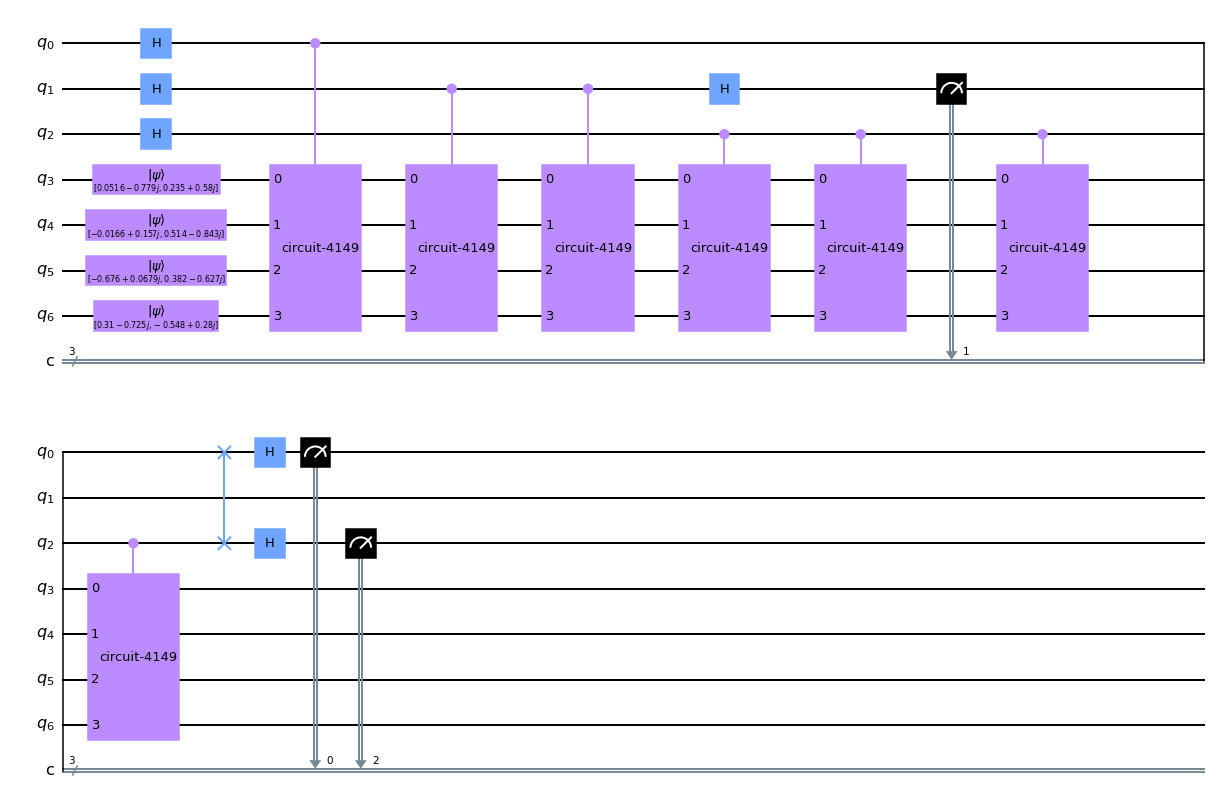

In [28]:
qpee = qpe(3,unitary)
display(qpee.draw())

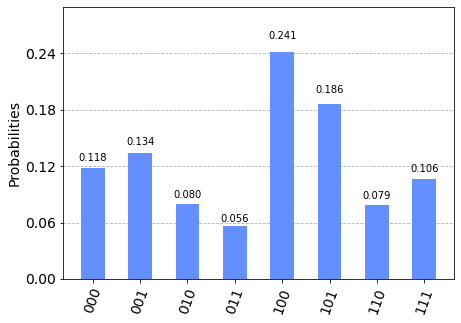

In [15]:
from qiskit import execute
simulator = Aer.get_backend('qasm_simulator')
result = execute(qpee, backend = simulator, shots = 1000).result()
plot_histogram(result.get_counts(qpee))

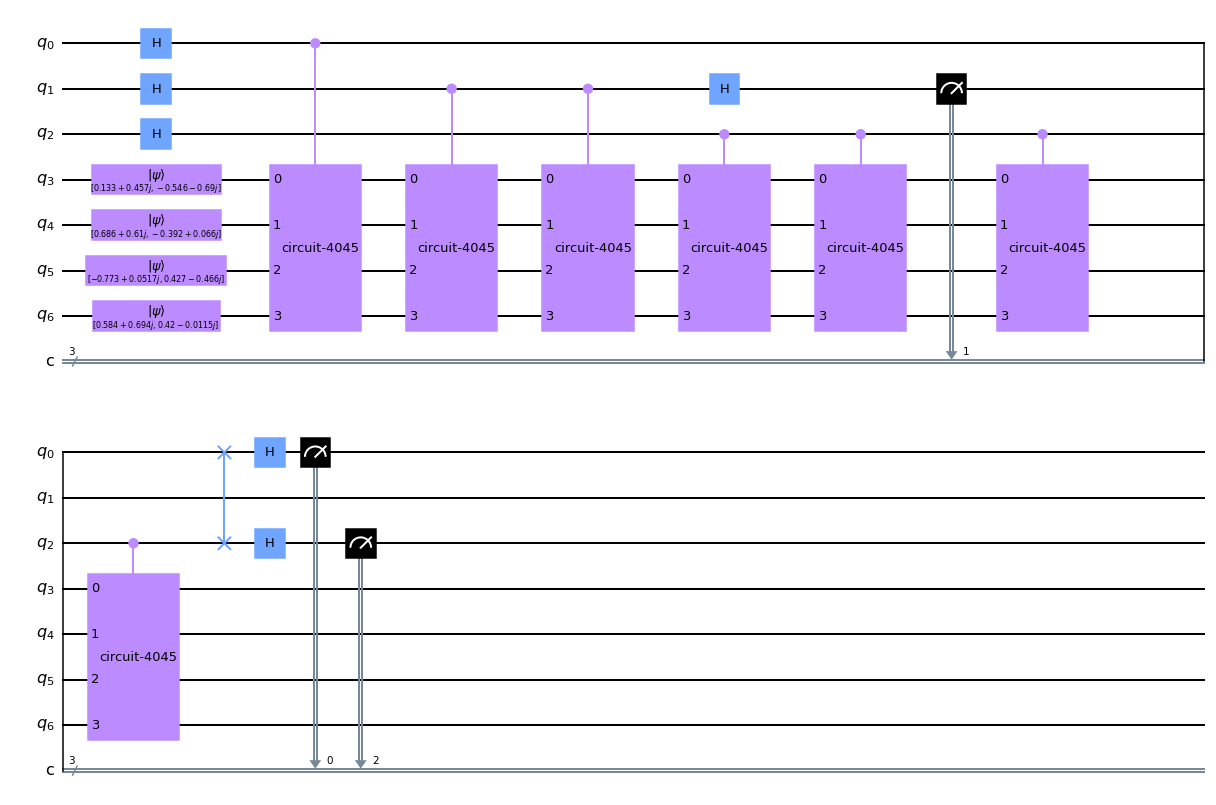

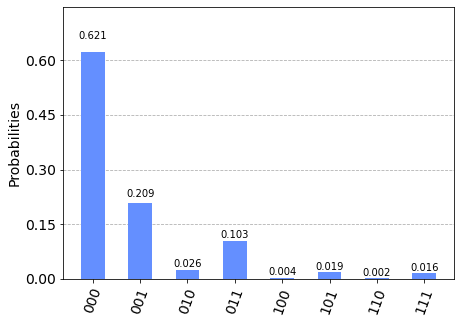

In [30]:
qpee = qpe(3,UPP_Gate)
display(qpee.draw())
simulator = Aer.get_backend('qasm_simulator')
result = execute(qpee, backend = simulator, shots = 1000).result()
plot_histogram(result.get_counts(qpee))

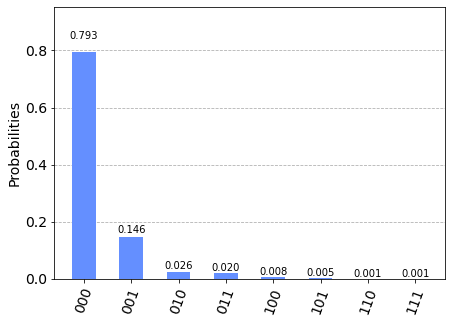

In [37]:
qpee = qpe(3,unitary)
simulator = Aer.get_backend('qasm_simulator')
result = execute(qpee, backend = simulator, shots = 1000).result()
plot_histogram(result.get_counts(qpee))

# Now Implement this time evolution for the deutron hamiltonian

In [11]:
from qiskit.opflow import I, X, Z, Y
import scipy
from qiskit.quantum_info.operators import Operator, Pauli
H2_op = (5.906709 * I ^ I) + \
        (0.218291 * Z ^ I) - \
        (6.125 * I ^ Z) - \
        (2.143304 * X ^ X) - \
        (2.143304 * Y ^ Y)
H2_op = H2_op.to_matrix()
H2_op = complex(0,-t)*H2_op
U2_op = scipy.linalg.expm(H2_op)

In [12]:
#QC for UPP
def qcd(p,q):
    qcd = QuantumCircuit(2)
    qcd.unitary(U2_op,[0,1])
    qcd = transpile(qcd)
    return qcd #just to see 

def evoloperatord(w):
    evoloperatord = QuantumCircuit(w)
    for p in range(w):
        for q in range(w):
            if (q > p):
                evoloperatord = evoloperatord.compose(qcd(0,1),[p,q])
    return evoloperatord

#converting the circuit into a controlled gate
UPd_Gate = evoloperatord(4).to_gate().control(1)

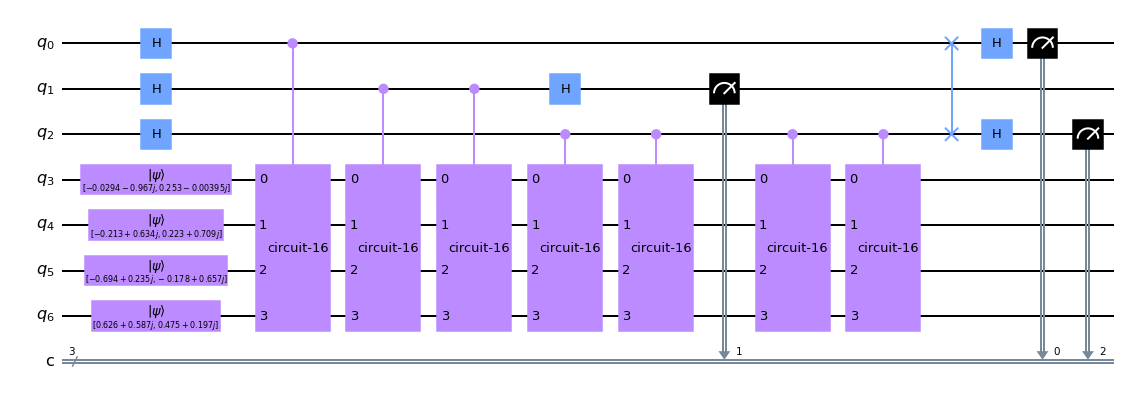

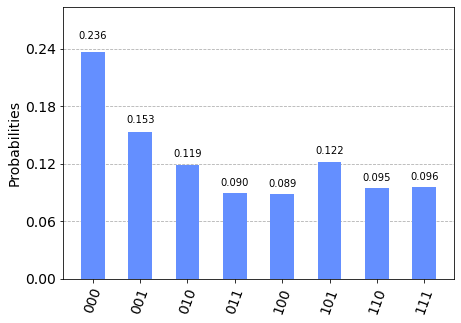

In [16]:
qpee = qpe(3,UPd_Gate)
display(qpee.draw())
simulator = Aer.get_backend('qasm_simulator')
result = execute(qpee, backend = simulator, shots = 1000).result()
plot_histogram(result.get_counts(qpee))